# NLP track project


The goal of this project is to guide you through the latest techniques in NLP, we have chosen to frame that journey around the problem of *Neural Machine Translation (NMT)*, More specifically english-spanish translation. 

The motivation for centering around this particular problem is that it's a complex one that has been revolutionized lately. So It will guide you from the basics to the latest SoA techniques.

The reason we choose English and Spanish is purely because we happen to know both of them, if you would like to explore other language feel free to do so but make sure you have a proper dataset that you can use.

## 1. Baseline

As a baseline we will first train a simple encoder-decoder architecture. The code is based on the [seq2seq notebook](https://github.com/fastai/course-nlp/blob/master/7-seq2seq-translation.ipynb) from the [lesson 12](https://www.youtube.com/watch?v=IfsjMg4fLWQ&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=13&t=0s) of the Fast.ai's NLP course.

### 1.1 Dataset

The dataset we will use was build by [Open Subtitles](https://www.opensubtitles.org/) and consists of movie and series subtitles, we chose this dataset over the alternatives because it contains casual and more simple language than the alternatives (UN resolutions, EU parlament sessions, etc). You can look at the alternatives on this [amazing site](http://opus.nlpl.eu/).

Unfurtunately the spanish used is from Spain, not sure why the Latin American version of the subtitles is not available.

The dataset is extremely large and not in a great format, you can see how we processed it on [this notebook](./subtitles-download.ipynb). There is no need to run it, ask for the csv file with the final result.

In [1]:
import pandas as pd
from fastai.text import *

base_path = Path('/data/NLP_track/')

torch.cuda.set_device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce GTX 980 Ti'

In [2]:
df = pd.read_csv(base_path/'subtitles.csv')

/home/javiber/.local/share/virtualenvs/javiber-jarMRqt3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(len(df))
df.sample(5)

7990657


,files,sub_id,en,es
2386520,en/2010/1570179/3663037.xml#es/2010/1570179/36...,112,But I 'm hoping they 'll be more cooperative w...,Pero espero que sean más cooperativos cuando s...
998663,en/2002/512294/5895863.xml#es/2002/512294/5179...,535,You came back for me .,Volviste por mí .
989442,en/2002/512254/5235403.xml#es/2002/512254/5183...,782,He 's not going to be all right .,Él no va a estar bien .
1303299,en/2005/749711/178777.xml#es/2005/749711/40301...,570,I 'm fine .,Estaré bien .
3217283,en/2011/1832848/4659172.xml#es/2011/1832848/51...,544,"At this point in time , I 'm pretty worried .","A esta altura , estoy preocupado ."


In [4]:
df.isna().sum()

files     0
sub_id    0
en        8
es        6
dtype: int64

In [3]:
df.dropna(inplace=True)
df.isna().sum()

files     0
sub_id    0
en        0
es        0
dtype: int64

In [4]:
df = df.sample(50000, random_state=42)

### 1.2 Tokenization and Numericalization

Unfurtunately the dataset was already tokenized, that's why you see spaces around punctuation marks. Not a big deal but we'd have rather the raw messages.

Anyway for this baseline we will use the default settings from fast.ai which is to use spaCy's tokenizer.

#### 1.2.1 Data collate

In order to run the RNN in parallel for a whole batch, all examples in a batch must have the same size. 
To accomplish this we'll add padding where necessary. 

Fast.ai has a [collate](https://docs.fast.ai/text.data.html#pad_collate) that does something similar but just in the Xs because is meant to be used on sentence classification, on seq2seq we need to padd both Xs and Ys.

In [2]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x = max([len(s[0]) for s in samples])
    max_len_y = max([len(s[1]) for s in samples])
    
    # create matrices of the target size we want (batch_lenght x max_sentence_lenght_in_batch) full of padding
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    
    if backwards: 
        pad_first = not pad_first
    
    for i, s in enumerate(samples):
        # replace the part of the correct part of the padded matrices with the actual values
        if pad_first: 
            res_x[i, -len(s[0]):] = LongTensor(s[0])
            res_y[i, -len(s[1]):] = LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):] = LongTensor(s[0])
            res_y[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: 
        res_x,res_y = res_x.flip(1),res_y.flip(1)
    
    return res_x,res_y

#### 1.2.2 Custom databunch

On the training set, we don't want to mix really long senteces with really short because that'd create lots of padding, instead we'll use fast.ai's `SortishSampler` to keep the sentences of a batch relatively the same size while also having some randomization.

In [3]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    
    @classmethod
    def create(
            cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
           dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
            **dl_kwargs) -> DataBunch:
        """
        Function that transform the `datasets` in a `DataBunch` for classification. 
        Passes `**dl_kwargs` on to `DataLoader()`
        """
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = bs if val_bs is None else val_bs 
        
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        
        # Sample data randomly but trying to keep the lenghts similar
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
            
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)
    
    
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [7]:
src = (Seq2SeqTextList
       .from_df(df, path=base_path, cols='en')
       .split_by_rand_pct(seed=42)
       .label_from_df(cols='es', label_cls=TextList))

#### 1.2.3 Analyze sentence length
Some sentences are extremely large so we will remove those outliers

In [8]:
x_lengths = [len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items]
np.percentile(x_lengths, 90), np.max(x_lengths)

(18.0, 81)

In [9]:
y_lengths = [len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items]
np.percentile(y_lengths, 90), np.max(y_lengths)

(17.0, 79)

In [11]:
func = lambda x,y: len(x) > 20 or len(y) > 20
filt = array([func(x, y) for x,y in zip(src.x.items, src.y.items)])

In [16]:
sum(filt)

3197

In [19]:
src.x[0].data

array([   2,    5, 1673, 1050, 1050,   10,   20,   17, 1814,   23,  571,    9])

In [14]:
type(src)

fastai.data_block.LabelLists

In [15]:
type(src.x)

__main__.Seq2SeqTextList

In [ ]:
fastai

In [12]:
src = src.filter_by_func()

In [13]:
len(src.train) + len(src.valid)

45998

#### 1.2.4 Visualize and save dataset

In [14]:
bs = 128

In [15]:
data = src.databunch(bs=bs)

In [16]:
data.show_batch()

text,target
xxbos i don ' t like the banks 'cause of the xxunk and the screaming and all the xxunk .,xxbos xxmaj no me gustan los bancos por la xxunk y los gritos y toda la xxunk .
"xxbos - xxmaj okay , all right , that xxunk lost you another week of tv and video xxunk .","xxbos - xxmaj bien , muy bien , esa mentira acaba de xxunk otra semana sin tele o xxunk ."
"xxbos xxmaj now , now , xxmaj xxunk - xxmaj xxunk - xxmaj san , please don ' t .","xxbos xxmaj vamos , vamos , xxmaj xxunk - xxmaj xxunk xxmaj san , por favor , no ..."
"xxbos xxmaj xxunk xxmaj xxunk has won by around xxunk xxunk votes in his xxunk seat , xxmaj xxunk .","xxbos xxmaj xxunk xxmaj xxunk xxunk aproximadamente xxunk xxunk xxmaj votos su asiento xxunk , xxmaj xxunk ."
"xxbos xxmaj almost all the xxunk have been let out of the room , only the actual xxunk remain .","xxbos xxmaj casi todos los espectadores han dejado la sala , solo quedan las partes ."


>**Note:** we didn't tell fast.ai what tokenizer it should use for spanish so it's using the english one

In [18]:
data.save()

#### 1.2.4 Load saved databunch

In [4]:
data = load_data(base_path, bs=128)

### 1.3 Embeddings

We will use the embedings from [fastText](https://fasttext.cc/docs/en/support.html) because they have pretrained models that are good enough for our baseline.

#### 1.3.1 Download pretrained word vectors

In [ ]:
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz -P {path}

In [ ]:
# ! gunzip {path}/cc.en.300.bin.gz
# ! gunzip {path}/cc.es.300.bin.gz

In [33]:
import fasttext as ft

In [34]:
es_vecs = ft.load_model(str((base_path/'cc.es.300.bin')))
en_vecs = ft.load_model(str((base_path/'cc.en.300.bin')))

In [35]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w: vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = 0
    for i, w in enumerate(itos):
        try: 
            wgts[i] = tensor(vec_dic[w])
        except: 
            miss += 1
    print(f'{miss} missing words')
    return emb

emb_enc = create_emb(en_vecs, data.x.vocab.itos)
emb_dec = create_emb(es_vecs, data.y.vocab.itos)

emb_enc.weight.size(), emb_dec.weight.size()

30 missing words
36 missing words


(torch.Size([5808, 300]), torch.Size([7104, 300]))

>**NOTE**: the words in our vocabulary that are missing on the fastText's one will be set to random vectors

In [36]:
torch.save(emb_enc, base_path/'en_emb.pth')
torch.save(emb_dec, base_path/'es_emb.pth')

#### 1.3.2 Load saved embeddings

In [5]:
emb_enc = torch.load(base_path/'en_emb.pth')
emb_dec = torch.load(base_path/'es_emb.pth')

### 1.4 Model

The Model we will use is the classic Encoder-Decoder, using a GRU to encode the meaning of the sentence in the original language into a fixed-size vector that the decode will convert into the target language, hopefully conservint the meaning.


<center style="margin-top: 20px">
    <video src="images/enc_dec.mp4" width="80%" controls autoplay muted loop></video>
</center>


<center>
    <i>Diagram from Jay Alammar's <a href="http://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Visualizing A Neural Machine Translation Model</a></i></center>

In [6]:
class EncDecRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1, tf_weight=0):
        super().__init__()
        
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(
            self.em_sz_enc, nh, num_layers=nl, dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(
            self.em_sz_dec, self.em_sz_dec, num_layers=nl, dropout=0.1, batch_first=True)
        
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.tf_weight = tf_weight  # teacher forcing weight
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return outp, h
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            outp, h = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): 
                break
                
            # Teacher forcing
            if (targ is not None) and (random.random() < self.tf_weight):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): 
        return one_param(self).new_zeros(self.nl, bs, self.nh)

In [7]:
xb, yb = next(iter(data.valid_dl))
xb.shape

torch.Size([128, 20])

In [7]:
model = EncDecRNN(emb_enc, emb_dec, 256, 20, tf_weight=1)
model

EncDecRNN(
  (emb_enc): Embedding(5808, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(7104, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=7104, bias=True)
)

> **Note:** we are using teacher forcing with prob of 1 so that we can compare this result to the ones with transformer (which also use teacher forcing with prob of 1)

### 1.6 Metrics and loss functions

#### 1.6.1 Cross-Entropy loss

In [8]:
def cross_entropy(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: 
        out  = F.pad(out, (0, 0, 0, targ_len - out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: 
        targ = F.pad(targ, (0, out_len - targ_len, 0, 0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

#### 1.6.2 Token-level accuracy 

In [9]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: 
        out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len > targ_len: 
        targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

#### 1.6.3 BLEU

BLEU is a very used meassurement on NMT and in seq2seq in general, is important to know how it works and its limitations, I strongly recommend reading Rachael Tatman's [post](https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213) about it

In [5]:
class NGram():
    def __init__(self, ngram, max_n=5000): 
        self.ngram,self.max_n = ngram,max_n
        
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): 
            return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    
    def __hash__(self): 
        return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams, targ_grams = get_grams(pred, n, max_n=max_n), get_grams(targ, n, max_n=max_n)
    pred_cnt, targ_cnt = Counter(pred_grams), Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g, c in pred_cnt.items()]), len(pred_grams)

class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len, self.targ_len, self.corrects, self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred, targ in zip(last_output.cpu().numpy(), last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c, t = get_correct_ngrams(pred, targ, i + 1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### 1.5 Training

In [11]:
from fastai.callbacks import SaveModelCallback

learn = Learner(
    data, model, loss_func=cross_entropy, 
    metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))])

learn.callbacks.append(
    SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='baseline'))

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-03
Min loss divided by 10: 2.29E-03


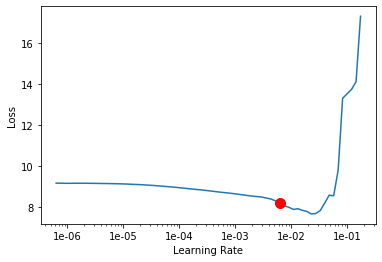

In [14]:
learn.recorder.plot(suggestion=True)

In [15]:
learn.fit_one_cycle(4, 3e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.580141,2.943090,0.569072,0.273858,00:19
1,3.840177,2.816740,0.549650,0.251734,00:19
2,3.464854,2.669522,0.576558,0.296858,00:18
3,3.365971,3.272397,0.511141,0.332937,00:17


Better model found at epoch 0 with valid_loss value: 2.9430902004241943.
Better model found at epoch 1 with valid_loss value: 2.8167402744293213.
Better model found at epoch 2 with valid_loss value: 2.6695215702056885.


### 1.6 Cualitative evaluation

In [13]:
learn.load('baseline');

In [14]:
model.eval()
model.cpu();

In [15]:
def greedy_decode(inp):
    out =  model(inp)
    return out.argmax(-1)

#### 1.6.1 Beam search

Not a good implementation of beam search.

In [6]:
def select_nucleus(probs, p=0.1, max_length=5):
    idxs = torch.argsort(probs, descending=True)
    res, cumsum = [], 0.
    for idx in idxs:
        res.append(idx)
        cumsum += probs[idx]
        if cumsum > p or len(res) >= max_length: 
            return res

In [17]:
def beam_decode(inp, bos_idx=2, unk_idx=0, pad_idx=1, beam_size=5, nucleus=0.3, no_unk=False):
    h = model.encoder(1, inp)
    
    finised = []  # finished phrases
    next_word = None
    current_ys = [(inp.new_zeros(1).long() + bos_idx, 0)]
    while current_ys:
        next_ys = []
        for ys, path_score in current_ys:
            out, h = model.decoder(ys[None, -1], h)
            probs = F.softmax(out[0], dim=-1)
            
            if no_unk:
                probs[unk_idx] = -float('Inf')
            
            likely = select_nucleus(probs, p=nucleus)
            chosen_words = random.sample(likely, k=min(beam_size, len(likely)))
            
            for y in chosen_words:
                phrase = torch.cat([ys, 
                        torch.Tensor([y]).long()], dim=0)
                
                score = path_score + torch.log(probs[y])
                
                if y == pad_idx or len(phrase) > 20:
                    finised.append((phrase, score))
                else:
                    next_ys.append((phrase, score))
                
        current_ys = sorted(next_ys, key=lambda k: k[1], reverse=True)[:beam_size]
    return sorted(finised, key=lambda k: k[1]/len(k[0]), reverse=True)[0][0]

In [7]:
def pretty(text_):
    if isinstance(text_, text.data.Text):
        text_ = text_.text
    maj = False
    up = False
    tokens = []
    for t in text_.split(' '):
        if t in ['xxbos']:
            continue
        elif t == 'xxmaj':
            maj = True
            continue
        elif t == 'xxup':
            up = True
            continue
        if maj:
            t = t[0].upper() + t[1:]
            maj = False
        if up:
            t = t.upper()
            up = False
        tokens.append(t)
    return ' '.join(tokens)

In [8]:
test_phrases = ['Let it go', 'I am your father', 'You talking to me?', 'A census taker once tried to test me. I ate his liver with some fava beans and a nice Chianti.', 'I\'ll be back.', 'I see dead people.', 'Houston, we have a problem.', 'Say hello to my little friend!', 'I did not hit her! I did not! Oh hi, Mark.', 'I\'m king of the world!', 'This is Sparta!', 'I want to play a game.', 'I have had it with these motherfucking snakes on this motherfucking plane!', 'You\'re a wizard, Harry.', 'With great power comes great responsibility.', 'I don\'t like sand. It\'s all coarse, and rough, and irritating. And it gets everywhere.', 'Not the bees!', 'Why so serious?', 'I\'m gonna steal the Declaration of Independence.', 'You shall not pass!', 'Are you not entertained?', 'King Kong ain\'t got shit on me!', 'I live my life a quarter mile at a time.', 'Water? Like out of the toilet?', 'They may take our lives, but they\'ll never take our freedom!', 'I will look for you, I will find you, and I will kill you.', 'My precious.', 'The first rule of Fight Club is: You do not talk about Fight Club.', 'You\'re gonna need a bigger boat.']

In [21]:
tokenizer = Tokenizer()
tok = SpacyTokenizer('en')

def show_predictions():
    for x in test_phrases:
        x = torch.tensor([[data.x.vocab.stoi[t] for t in tokenizer.process_text(x, tok)]])
        print(pretty(data.x.reconstruct(x[0])))
        print('~' * 10 + ' greedy ' + '~' * 10)    
        print(pretty(data.y.reconstruct(greedy_decode(x)[0])))
        print('~' * 10 + '  beam  ' + '~' * 10)    
        print(pretty(data.y.reconstruct(beam_decode(x, no_unk=True))))
        print('=' * 50 + '\n')
show_predictions()

Let it go
~~~~~~~~~~ greedy ~~~~~~~~~~
Xxunk xxunk
~~~~~~~~~~  beam  ~~~~~~~~~~
De

i am your father
~~~~~~~~~~ greedy ~~~~~~~~~~
¿ No que que que que que
~~~~~~~~~~  beam  ~~~~~~~~~~
¿ Que que

You talking to me ?
~~~~~~~~~~ greedy ~~~~~~~~~~
Xxunk
~~~~~~~~~~  beam  ~~~~~~~~~~
Cómo

a xxunk xxunk once tried to test me . i ate his xxunk with some xxunk xxunk and a nice Xxunk .
~~~~~~~~~~ greedy ~~~~~~~~~~
No xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk
~~~~~~~~~~  beam  ~~~~~~~~~~
No que que y

i 'll be back .
~~~~~~~~~~ greedy ~~~~~~~~~~
No que que que . . .
~~~~~~~~~~  beam  ~~~~~~~~~~
No que .

i see dead people .
~~~~~~~~~~ greedy ~~~~~~~~~~
No que que que que que xxunk
~~~~~~~~~~  beam  ~~~~~~~~~~
No a .

Xxunk , we have a problem .
~~~~~~~~~~ greedy ~~~~~~~~~~
Xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk
~~~~~~~~~~  beam  ~~~~~~~~~~
,

Say hello to my little friend !


### Extras

This baseline was meant to provide a basic understanding of the problem but there are things that can be improved and potentially re-used for the more complex models. If you decide so, here are some things you can add to the baseline to get your feet wet, if you have other things to add to this list don't hessitate to propose it. 

- Align batches in a way that allows us to keep h between batches, similar to what is done in [notebook 6](https://github.com/fastai/course-nlp/blob/master/6-rnn-english-numbers.ipynb) of fast.ai's course.
- Handle UNK better using a sub-word tokenizer like [BPT](https://github.com/rsennrich/subword-nmt) or [SentencePiece](https://github.com/google/sentencepiece). This would render fastext pre-trained embeddings obsolete so an alternative is necessary.
- Train with more data and for longer.
- [RAdam](https://medium.com/@lessw/new-state-of-the-art-ai-optimizer-rectified-adam-radam-5d854730807b) a new optimizer that can easily be integrated and promises better results.
- Beam search, we are using a variant here, but didn't test it in depth. Take a look to [this paper](https://arxiv.org/abs/1904.09751) for an analysis on open-ended and non-open-ended text generation.
- Try [QRNN](https://arxiv.org/abs/1611.01576) instead of GRU.

## 2. Advanced solutions

Now that we have a basic understanding of the problem we will dive into more novel solutions. The idea here is that you choose an approach that you want to try and implement it. It's beeter if you try a different solution than mine so that we can compare results later.

Some ideas are:

- ELMO embeddings. Pre-trained weights just in english.
- BERT embeddings. English and multilingual pre-trained models could come handy.
- TransformXL.
- XLM embeddings. They have a [multilingual model](https://github.com/facebookresearch/XLM#pretrained-cross-lingual-language-models) pre-trained.
- Distill some of the complex embeddings as described on [this paper](https://arxiv.org/pdf/1503.02531.pdf).
- [LightConv and DynamicConv](https://arxiv.org/abs/1901.10430), an alternative to attention, [pytorch implementation](https://github.com/pytorch/fairseq) is available.

Training one of these more advanced models from scratch is quite lengthy and it might not be possible on the available hardware we have. As a reference, I trained ULMFit from scratch on the whole wikipedia in spanish on a 2080 Ti with 11GB and took ~25hrs ([notebook](./nn-spanish.ipynb)).

For this reason I highly recommend using pre-trained models and transfer learning where possible (for english there are pre-trained weights available for all models but for spanish there might not be available).

Keep an eye on the latest news, NLP is in the middle of a revolution so new things come up each week.

### 2.1 Transformer

Vanilla transformer. Implementation taken from fast.ai's [8th notebook](https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb). I just changed it a bit to use some of the classes/functions that come in the library and used FastText pre-trained embeddings instead of random ones.

Also highly recommend checking the [Annotated paper](http://nlp.seas.harvard.edu/2018/04/03/attention.html) with PyTorch code.

<img src="images/transformer.png"> </img>

In [9]:
import copy

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [10]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))
    
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [11]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, emb, inp_p=0.):
        super().__init__()
        self.emb_sz = emb.embedding_dim
        self.embed = emb
        self.pos_enc = PositionalEncoding(self.emb_sz)  # https://github.com/fastai/fastai/blob/master/fastai/text/models/transformer.py#L11
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt,self.k_wgt,self.v_wgt = [nn.Linear(
            d_model, n_heads * d_head, bias=bias) for o in range(3)]
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                            ).permute(0, 2, 1, 3)
    
    def _apply_attention(self, q, kv, mask=None):
        bs, seq_len = q.size(0),q.size(1)
        wq, wk, wv = map(lambda o: self.create_attn_mat(*o,bs),
                       zip((q, kv, kv),(self.q_wgt, self.k_wgt, self.v_wgt)))
        attn_score = wq @ wk.transpose(2,3)
        if self.scale: 
            attn_score /= math.sqrt(self.d_head)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

In [13]:
class EncoderBlock(Module):
    "Basic block of a Transformer model."
    # Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        
        self.mhra = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
        self.sublayer = clones(SublayerConnection(d_model, p), 2)

    def forward(self, x, **kwargs):
        x = self.sublayer[0](x, lambda x: self.mhra(x, x, **kwargs))
        return self.sublayer[1](x, self.ff)
    
        return self.ff()

In [14]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
        self.sublayer = clones(SublayerConnection(d_model, p), 3)
    
    def forward(self, x, enc, mask_out=None): 
        x = self.sublayer[0](x, lambda x: self.mha1(x, x, mask_out))
        x = self.sublayer[1](x, lambda x: self.mha2(x, enc))
        return self.sublayer[2](x, self.ff)

In [15]:
def get_output_mask(inp, pad_idx=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].bool()

In [16]:
class Transformer(Module):
    def __init__(
            self, emb_enc, emb_dec, n_layers=6, n_heads=8, d_model=300, d_head=32, 
            d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        
        self.enc_emb = TransformerEmbedding(emb_enc, p)
        self.dec_emb = TransformerEmbedding(emb_dec, 0.)
        
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        
        self.out = nn.Linear(d_model, emb_dec.num_embeddings)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)
        
        enc, out = self.enc_emb(inp), self.dec_emb(out)
        
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)

> **Note:** Transformer is allways using TeacherForcing 

In [17]:
def shift_tfm(b):
    "Adds the shifted y to the dataset"
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x, y[:,:-1]], y[:,1:]

data.add_tfm(shift_tfm)

In [36]:
model = Transformer(
    emb_enc=emb_enc, 
    emb_dec=emb_dec)

#### 2.1.2 Training

In [37]:
learn = Learner(
    data, model, 
    loss_func=FlattenedLoss(
        LabelSmoothingCrossEntropy, axis=-1),  # the paper reports better results with label smoothing
    metrics=[accuracy, CorpusBLEU(len(data.y.vocab.itos))], 
)

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-03
Min loss divided by 10: 7.59E-02


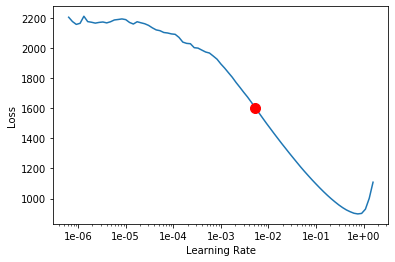

In [39]:
learn.recorder.plot(suggestion=True)

In [40]:
learn.fit_one_cycle(4, 3e-2)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,35.909977,33.639030,0.540811,0.395665,00:46
1,9.407427,6.137264,0.564513,0.392775,00:48
2,4.319383,3.770583,0.583217,0.403667,00:48
3,3.366669,3.444857,0.601924,0.409635,00:49


In [41]:
learn.save('transformer-fastext')

### 2.2 ULMFit with transformers

I will use the embeddings from [ULMFit](https://arxiv.org/pdf/1801.06146.pdf) in english as the encoder. The decoder layer will be the same but it will also receive spanish embeddings from ULMFit. 

#### 2.2.1 English embeddings

We will start with ULMFit's pre-trained model for english and fine-tuned it on our subtitles

In [186]:
path = base_path/'lm_en'

In [187]:
data_lm = (
    TextList
        .from_df(df, path=path, cols='en')
        .split_by_rand_pct(0.1, seed=42)  # We randomly split for validation
        .label_for_lm()  # We want to do a language model so we label accordingly
        .databunch(bs=48, num_workers=12))

In [188]:
data_lm.save()

In [109]:
data_lm = load_data(path, bs=48)

In [189]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1.0)
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(25784, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(25784, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=25784, bias=True)
    (output_dp): RNNDropout()
  )
)

In [190]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.63E-02


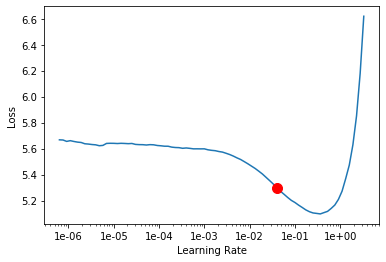

In [191]:
learn_lm.recorder.plot(suggestion=True)

In [192]:
learn_lm.fit_one_cycle(2, 3e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.728145,4.841912,0.301525,04:02
1,4.292948,3.955799,0.335768,04:06


In [193]:
learn_lm.save(f'en_fine_tuned_1')

In [194]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, slice(3e-2/(2.6**4), 3e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.777594,3.648559,0.367891,04:59
1,3.603667,3.507471,0.382600,05:01
2,3.531927,3.433340,0.390342,05:02
3,3.480464,3.387439,0.394144,05:01
4,3.395352,3.348521,0.397989,05:01
5,3.317074,3.316249,0.401825,05:02
6,3.219466,3.301881,0.404282,05:02
7,3.172760,3.305299,0.404410,05:01


In [195]:
learn_lm.save(f'en_fine_tuned')
learn_lm.save_encoder(f'en_fine_tuned_enc')

In [111]:
learn_lm.load(f'en_fine_tuned')
learn_lm.load_encoder(f'en_fine_tuned_enc')

In [196]:
encoder = get_model(learn_lm.model)[0]

In [197]:
with open(base_path/'ulm_en_enc.pkl', 'wb') as f:
    torch.save(encoder,f)

#### 2.2.2 Spanish embeddings

We'll do the same for spanish, in this case the pre-trained spanish LM was trained by me on [this notebook](./nn-spanish.ipynb)

In [203]:
del data_lm
del learn_lm
import gc
gc.collect()
torch.cuda.empty_cache()

In [198]:
path = base_path/'lm_es'

In [199]:
data_lm_es = (
    TextList
        .from_df(df, path=path, cols='es')
        .split_by_rand_pct(0.1, seed=42)  # We randomly split and keep 10% for validation
        .label_for_lm()  # We want to do a language model so we label accordingly
        .databunch(bs=48, num_workers=12))

In [200]:
data_lm_es.save()

In [116]:
data_lm_es = load_data(path, bs=48)

In [201]:
learn_lm_es = language_model_learner(data_lm_es, AWD_LSTM, pretrained_fnames=[f'es_wt', f'es_wt_vocab'], drop_mult=1.0)

In [202]:
learn_lm_es.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-02
Min loss divided by 10: 3.63E-02


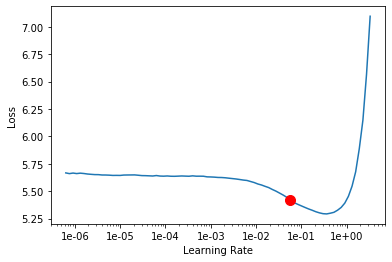

In [204]:
learn_lm_es.recorder.plot(suggestion=True)

In [205]:
learn_lm_es.fit_one_cycle(2, 3e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.161613,5.348360,0.287702,04:24
1,4.578285,4.179093,0.330367,04:29


In [206]:
learn_lm_es.save(f'es_fine_tuned_1')

In [ ]:
learn_lm_es.unfreeze()
learn_lm_es.fit_one_cycle(8, slice(3e-2/(2.6**4), 3e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.046064,3.888487,0.355104,05:21
1,3.848106,3.719486,0.372208,05:21
2,3.753581,3.634134,0.379355,05:21
3,3.684632,3.581652,0.383838,05:21


In [ ]:
learn_lm_es.save(f'es_fine_tuned')
learn_lm_es.save_encoder(f'es_fine_tuned_enc')

In [118]:
learn_lm_es.load(f'es_fine_tuned')
learn_lm_es.load_encoder(f'es_fine_tuned_enc')

In [ ]:
encoder = get_model(learn_lm_es.model)[0]

In [ ]:
with open(base_path/'ulm_es_enc.pkl', 'wb') as f:
    torch.save(encoder,f)

In [213]:
del learn_lm_es
del data_lm_es
import gc
gc.collect()
torch.cuda.empty_cache()

#### 2.2.3 Model

In [18]:
class ULMEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, ulm_enc, embedding_dim=400, p=0., pos=True):
        super().__init__()
        self.emb_sz = embedding_dim
        self.ulm_enc = ulm_enc
        self.pos_enc = None
        if pos:
            self.pos_enc = PositionalEncoding(self.emb_sz)  # https://github.com/fastai/fastai/blob/1.0.57/fastai/text/models/transformer.py#L11
        self.drop = nn.Dropout(p)
    
    def forward(self, inp): 
        self.ulm_enc.reset()  # reset hidden state of LSTM
        
        # take all hidden states of the last layer
        hs, _  = self.ulm_enc(inp)
        hs = hs[-1]
        
        if self.pos_enc:
            pos = torch.arange(0, inp.size(1), device=inp.device).float()
            return self.drop(hs * math.sqrt(self.emb_sz) + self.pos_enc(pos))
        else:
            return self.drop(hs * math.sqrt(self.emb_sz))
    
    
class Transformer(Module):
    def __init__(
            self, out_dim, n_layers=6, n_heads=8, d_model=400, d_head=32, 
            d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1, 
            position_encoder=True):
        
        with open(base_path/'ulm_en_enc.pkl', 'rb') as f:
            self.enc_emb = ULMEmbedding(torch.load(f), p=p)
                    
        with open(base_path/'ulm_es_enc.pkl', 'rb') as f:
            self.dec_emb = ULMEmbedding(torch.load(f), p=0)
        
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        
        self.out = nn.Linear(d_model, out_dim)
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        enc = self.encode(inp)
        return self.decode(enc, out)
    
    def encode(self, inp):
        enc = self.enc_emb(inp)
        return compose(self.encoder)(enc)
    
    def decode(self, enc, out):
        out = self.dec_emb(out)
        mask_out = get_output_mask(out, self.pad_idx)
        
        out = compose(self.decoder)(out, enc, mask_out)
        
        return self.out(out)

> **Note:** I can use the spanish embeddings without any masking because they only depend on previous words, if they were bi-directional we would be cheating as the embedding of a word could hint the next words in the target sentence

In [23]:
model = Transformer(len(data.y.vocab.itos))

#### 2.2.4 Training

In [44]:
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

learn = Learner(
    data, model, 
    loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
    metrics=[accuracy, CorpusBLEU(len(data.y.vocab.itos))],
    callback_fns=[partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3)],
)
learn.callbacks.append(SaveModelCallback(
    learn, every='improvement', monitor='valid_loss', name='uml-transformer-enc'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 2.75E-03


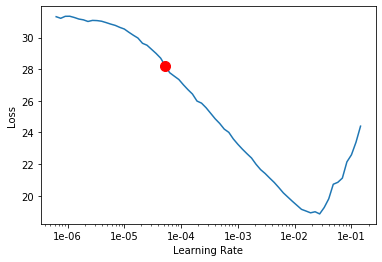

In [45]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [46]:
learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,6.558002,4.477090,0.584353,0.408594,01:38
1,3.787544,3.464381,0.639028,0.446606,01:41
2,3.492886,3.223813,0.671886,0.472002,01:39
3,3.353385,3.184466,0.678727,0.479429,01:41


Better model found at epoch 0 with valid_loss value: 4.477090358734131.
Better model found at epoch 1 with valid_loss value: 3.4643805027008057.
Better model found at epoch 2 with valid_loss value: 3.223813056945801.
Better model found at epoch 3 with valid_loss value: 3.1844663619995117.


### 2.3 Bigger model

In [19]:
model = Transformer(len(data.y.vocab.itos), n_layers=12, n_heads=12)

#### 2.3.1 training

In [18]:
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

learn = Learner(
    data, model, 
    loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
    metrics=[accuracy, CorpusBLEU(len(data.y.vocab.itos))],
    callback_fns=[partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3)],
)
learn.callbacks.append(
    SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='ulm-transformer-big-enc'))

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-05
Min loss divided by 10: 1.58E-03


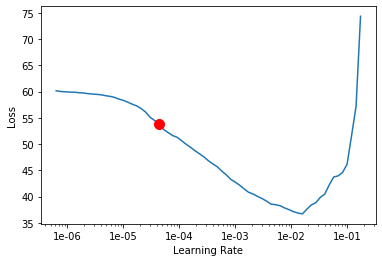

In [20]:
learn.recorder.plot(suggestion=True)

In [21]:
learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,5.880165,4.530049,0.580322,0.386800,03:07
1,4.053812,3.560559,0.651603,0.436420,03:09
2,3.732540,3.336047,0.676306,0.461640,03:08
3,3.589565,3.249422,0.682652,0.465569,03:07


Better model found at epoch 0 with valid_loss value: 4.530048847198486.
Better model found at epoch 1 with valid_loss value: 3.560558557510376.
Better model found at epoch 2 with valid_loss value: 3.3360471725463867.
Better model found at epoch 3 with valid_loss value: 3.249422311782837.


### 2.5 more data

In [4]:
data = load_data(base_path, base_path/'500k_data.pk', bs=64)

In [19]:
model = Transformer(len(data.y.vocab.itos), n_layers=12, n_heads=12)

In [20]:
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

learn = Learner(
    data, model, 
    loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
    metrics=[accuracy, CorpusBLEU(len(data.y.vocab.itos))],
    callback_fns=[partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3)],
)
learn.callbacks.append(
    SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='best'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 1.58E-03


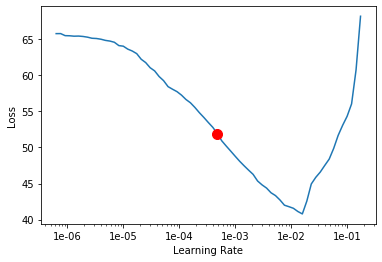

In [21]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(30, 3e-3)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.659268,2.650527,0.763749,0.529878,35:06
1,2.446970,2.509348,0.783937,0.557857,34:34
2,2.555975,2.535624,0.779521,0.551617,35:32


Better model found at epoch 0 with valid_loss value: 2.6505274772644043.
Better model found at epoch 1 with valid_loss value: 2.509348154067993.


In [22]:
learn.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,3.892902,3.785238,0.643308,0.406770,22:09
1,3.370652,3.214375,0.706582,0.462676,22:50
2,2.822632,2.835911,0.744514,0.504932,21:26
3,2.661791,2.620164,0.771951,0.540482,21:23
4,2.535577,2.507352,0.788304,0.564694,20:40
5,2.446908,2.429773,0.799433,0.580579,20:44
6,2.365362,2.387846,0.807118,0.592338,21:26
7,2.340757,2.349899,0.812553,0.600685,21:04
8,2.251286,2.321402,0.816426,0.607035,20:59
9,2.277723,2.304233,0.820483,0.613846,20:49


Better model found at epoch 0 with valid_loss value: 3.7852375507354736.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 1 with valid_loss value: 3.2143747806549072.
Better model found at epoch 2 with valid_loss value: 2.8359107971191406.
Better model found at epoch 3 with valid_loss value: 2.620164155960083.
Better model found at epoch 4 with valid_loss value: 2.5073516368865967.
Better model found at epoch 5 with valid_loss value: 2.4297730922698975.
Better model found at epoch 6 with valid_loss value: 2.3878464698791504.
Better model found at epoch 7 with valid_loss value: 2.34989857673645.
Better model found at epoch 8 with valid_loss value: 2.321401596069336.
Better model found at epoch 9 with valid_loss value: 2.3042333126068115.
Better model found at epoch 10 with valid_loss value: 2.2896721363067627.
Better model found at epoch 11 with valid_loss value: 2.2752795219421387.
Better model found at epoch 12 with valid_loss value: 2.269766330718994.
Better model found at epoch 13 with valid_loss value: 2.25537109375.
Better model found at epoch 14 with valid_loss value: 2.2

### Cualitative analysis

In [25]:
learn.load('ulm-transformer-bigger');

In [23]:
model.cpu();
model.eval();

In [24]:
def greedy_decode(
        inp, 
        unk_idx=0, 
        pad_idx=1,
        bos_idx=2, 
        no_unk=True):
    
    enc = model.encode(inp)
    
    ys = torch.ones(1, 1).fill_(bos_idx).type_as(inp.data)
    next_word = None
    while next_word != pad_idx:
        out = model.decode(enc, ys)
        if no_unk:
            out[0][-1][unk_idx] = -float('Inf')
            
        next_word = out[0][-1].argmax(0)
        next_word = next_word.data
        ys = torch.cat([ys, 
                        torch.tensor([[next_word]]).long()
                       ], dim=1)
    return ys

In [25]:
def beam_decode(inp, bos_idx=2, unk_idx=0, pad_idx=1, beam_size=5, nucleus=0.3, no_unk=False):
    enc = model.encode(inp)
    
    finised = []  # finished phrases
    next_word = None
    current_ys = [(inp.new_zeros([1]).long() + bos_idx, 0)]
    while current_ys:
        next_ys = []
        for ys, path_score in current_ys:
            out = model.decode(enc, ys.unsqueeze(0))
            probs = F.softmax(out[0, -1], dim=-1)
            
            if no_unk:
                probs[unk_idx] = -float('Inf')
            
            likely = select_nucleus(probs, p=nucleus)
            chosen_words = random.sample(likely, k=min(beam_size, len(likely)))
            
            for y in chosen_words:
                phrase = torch.cat([ys, y.unsqueeze(0).long()], dim=0)
                
                score = path_score + torch.log(probs[y])
                
                if y == pad_idx or len(phrase) > 20:
                    finised.append((phrase, score))
                else:
                    next_ys.append((phrase, score))
                
        current_ys = sorted(next_ys, key=lambda k: k[1], reverse=True)[:beam_size]
    return sorted(finised, key=lambda k: k[1]/len(k[0]), reverse=True)[0][0]

In [31]:
tokenizer = Tokenizer()
tok = SpacyTokenizer('en')

def show_predictions():
    for x in random.sample(test_phrases, 10):
        x = torch.tensor([[data.x.vocab.stoi[t] for t in tokenizer.process_text(x, tok)]])
        print('~' * 10 + ' greedy ' + '~' * 10)
        print(pretty(data.x.reconstruct(x[0])))
        print(pretty(data.y.reconstruct(greedy_decode(x)[0])))
        print('~' * 10 + '  beam  ' + '~' * 10)
        print(pretty(data.y.reconstruct(beam_decode(x, no_unk=True))))
        print('=' * 50 + '\n')
show_predictions()

I live my life a quarter mile at a time.
~~~~~~~~~~ greedy ~~~~~~~~~~
Vivo mi vida un cuarto de cuarto en un momento .
~~~~~~~~~~  beam  ~~~~~~~~~~
Vivo mi vida un cuarto de cuarto en un momento .

Why so serious?
~~~~~~~~~~ greedy ~~~~~~~~~~
¿ Por qué tan serio ?
~~~~~~~~~~  beam  ~~~~~~~~~~
¿ Por qué tan serio ?

I will look for you, I will find you, and I will kill you.
~~~~~~~~~~ greedy ~~~~~~~~~~
Te veré , te encontraré , y te mataré .
~~~~~~~~~~  beam  ~~~~~~~~~~
Te voy a buscar , te encontraré , y te mataré .

With great power comes great responsibility.I don't like sand. It's all coarse, and rough, and irritating. And it gets everywhere.
~~~~~~~~~~ greedy ~~~~~~~~~~
Con gran poder viene genial , hago un gran responsabilidad y es todo lo que se , y es todo lo que se hace .
~~~~~~~~~~  beam  ~~~~~~~~~~
Con gran poder viene genial , hago una gran responsabilidad y todo se ve en todas partes , y

A census taker once tried to test me. I ate his liver with some fava beans and a nice 